# Monthly timeseries for ERA5

In [77]:
from pathlib import Path 
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt 
import matplotlib as mpl
import cartopy.crs as ccrs

mpl.style.use("ccic.mplstyle")

In [28]:
data_path = Path('/scratch/ccic_record/data/')
ds = xr.open_dataset(data_path / 'ERA5' / 'era5_tcsw_tciw_tcc_1980_2023.nc') 
mask = xr.open_dataset(data_path / 'mask_24.nc')
# convert to int because interpolation does not work with bool dtype 
mask = mask.mask.astype(int)
# interpolate mask to ERA5 grid 
interpolated_mask = mask.interp(coords = {'longitude': ds.longitude.values, 'latitude': ds.latitude.values} )

In [40]:
# combine months from ERA5 with ERA5T
ERA5_combined =ds.sel(expver=1).combine_first(ds.sel(expver=5))
# add snow and column ice to get total ice water path 
tiwp= ERA5_combined.tcsw + ERA5_combined.tcsw
# total cloud cover fraction
ca= ERA5_combined.tcc

### Maps of cloud amount and total ice water path 

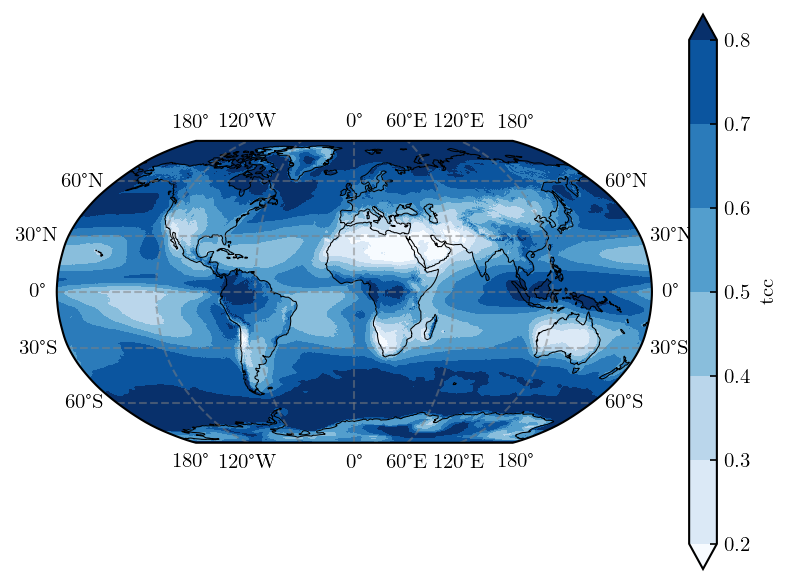

In [80]:
ax = plt.axes(projection=ccrs.Robinson())
ca.mean('time').plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    levels=[0.2,0.3,0.4,0.5,0.6,0.7,0.8],
    extend='both',
    colors=plt.cm.Blues)

ax.coastlines(
    resolution='110m') 
gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  draw_labels=True,
                  linewidth=1,
                  color='gray',
                  alpha=0.5,
                  linestyle='--')

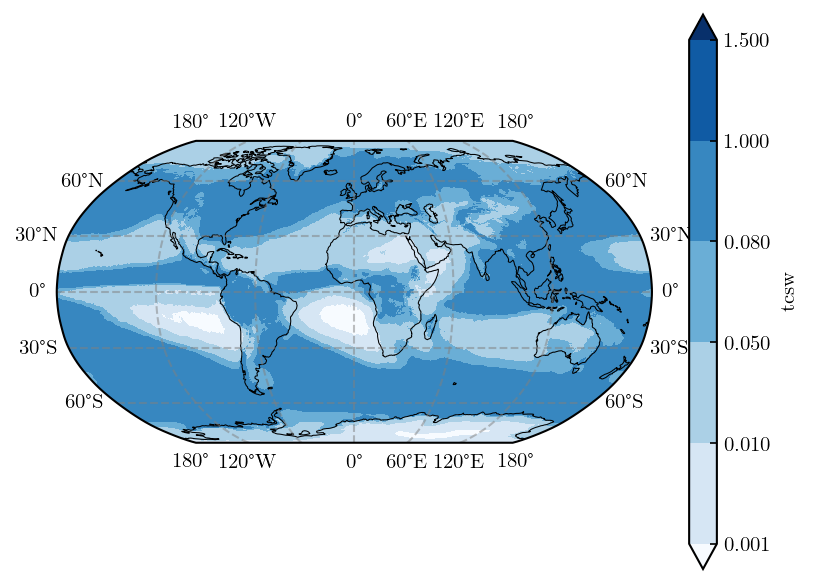

In [86]:
ax = plt.axes(projection=ccrs.Robinson())
tiwp.mean('time').plot(
    ax=ax,
    levels= [0.001,0.01,0.05,0.08,1,1.5], 
    transform=ccrs.PlateCarree(),
    colors=plt.cm.Blues)

ax.coastlines(
    resolution='110m') 
gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  draw_labels=True,
                  linewidth=1,
                  color='gray',
                  alpha=0.5,
                  linestyle='--')

### Calculate global means of iwp and cloud cover fraction with latitude weights and mask 

In [51]:
weights = np.cos(np.deg2rad(ds.latitude))
weights.name = "weights"
tiwp_weighted = tiwp.where(mask == 1 ).weighted(weights)
ca_weighted = ca.where(mask == 1 ).weighted(weights)
tiwp_global_mean = tiwp_weighted.mean(("longitude", "latitude"))
ca_global_mean = ca_weighted.mean(("longitude", "latitude"))

## Timeseries 

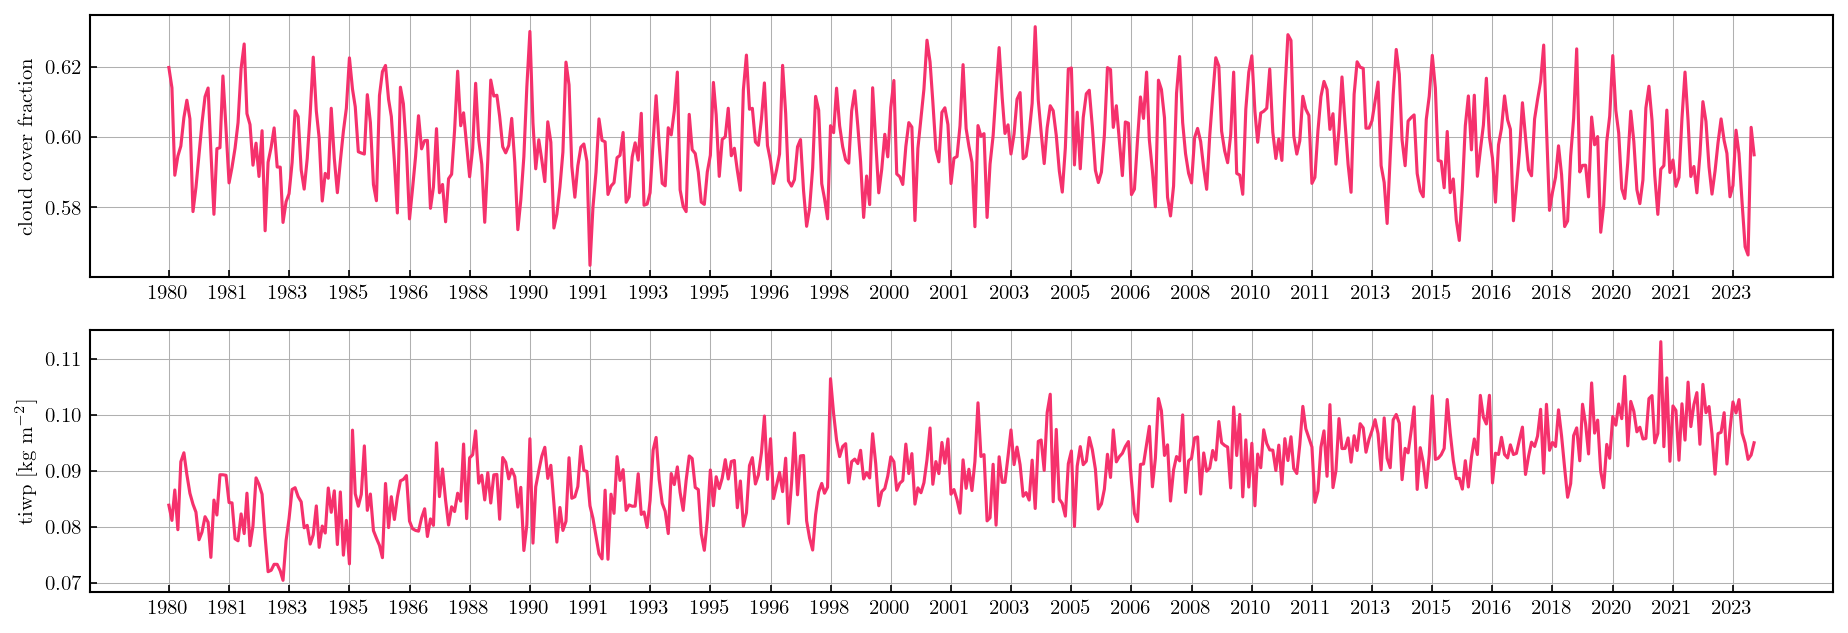

In [73]:
plt.figure(figsize=(15,5))

# monthly timeseries cloud amount 
plt.subplot(2,1,1)
plt.plot(ca_global_mean.time, ca_global_mean)
plt.xticks(ca.time[::20], ca.time.dt.year.values[::20])
plt.ylabel(r'cloud cover fraction')
plt.grid()


# monthly timeseries ice water path 
plt.subplot(2,1,2)
plt.plot(tiwp_global_mean.time, tiwp_global_mean)
plt.ylabel(r'tiwp [kg m$^{-2}]$')
plt.xticks(tiwp.time[::20], tiwp.time.dt.year.values[::20])
plt.grid()


plt.show()